# Risk Factors for Cardiovascular Heart Disease

Cilj ovog projekta je rešavanje **problema binarne klasifikacije**, gde se na osnovu demografskih, bioloških i životnih faktora predviđa prisustvo kardiovaskularne bolesti (`cardio`).

### Pregled skupa podataka
Skup podataka sadrži informacije o 70.000 ispitanika i obuhvata podatke o starosti, polu, telesnim merama, krvnom pritisku, nivou holesterola i glukoze, kao i navikama poput pušenja, konzumacije alkohola i fizičke aktivnosti.

### Važne napomene
- Atribut `age` je izražen **u danima**, a ne u godinama, što zahteva konverziju radi lakše interpretacije.
- Vrednosti krvnog pritiska (`ap_hi`, `ap_lo`) mogu sadržati **nelogične ili ekstremne vrednosti**, koje će biti razmotrene tokom obrade podataka.
- Atributi `cholesterol` i `gluc` predstavljaju **ordinalne kategorije**, a ne kontinualne vrednosti.
- Ciljna promenljiva `cardio` je binarna:
  - `0` – nema kardiovaskularne bolesti  
  - `1` – prisutna kardiovaskularna bolest


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv("heart_data.csv")

df.head()

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        70000 non-null  int64  
 1   id           70000 non-null  int64  
 2   age          70000 non-null  int64  
 3   gender       70000 non-null  int64  
 4   height       70000 non-null  int64  
 5   weight       70000 non-null  float64
 6   ap_hi        70000 non-null  int64  
 7   ap_lo        70000 non-null  int64  
 8   cholesterol  70000 non-null  int64  
 9   gluc         70000 non-null  int64  
 10  smoke        70000 non-null  int64  
 11  alco         70000 non-null  int64  
 12  active       70000 non-null  int64  
 13  cardio       70000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 7.5 MB


In [5]:
df.describe()

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,34999.500000,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,20207.403759,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17499.750000,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,34999.500000,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,52499.250000,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,69999.000000,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.isnull().sum()

index          0
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

**U datasetu nema praznih vrednosti, što nam olakšava preprocesiranje.**

In [7]:
df["cardio"].value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

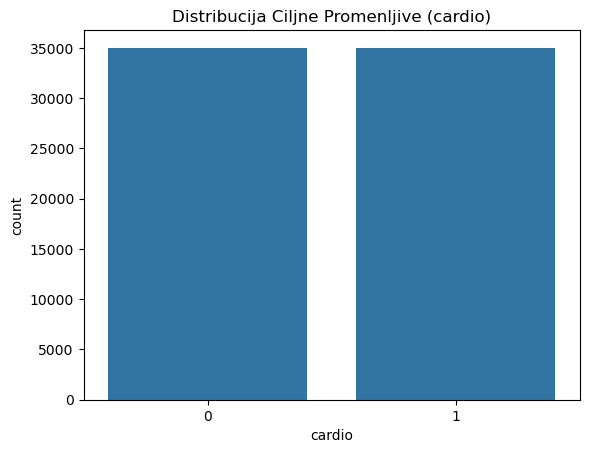

In [8]:
sns.countplot(x="cardio", data=df)
plt.title("Distribucija Ciljne Promenljive (cardio)")
plt.show()

**Vidimo da imamo skoro podjednako rasprostranjene vrednosti 0 i 1 koje označavaju da li osobe imaju ili nemaju kartiovaskularne bolesti.**

### Konverzija godina

Kolona `age` je predstavljena u danima. Za bolju analizu i razumljivost konvertovaćemo ih u godine.


In [9]:
df["age_years"] = df["age"] / 365.25
df.drop(columns=["age"], inplace=True)

df[["age_years"]].describe()

,age_years
count,70000.000000
mean,53.302850
std,6.754967
min,29.563313
25%,48.361396
50%,53.943874
75%,58.390144
max,64.922656


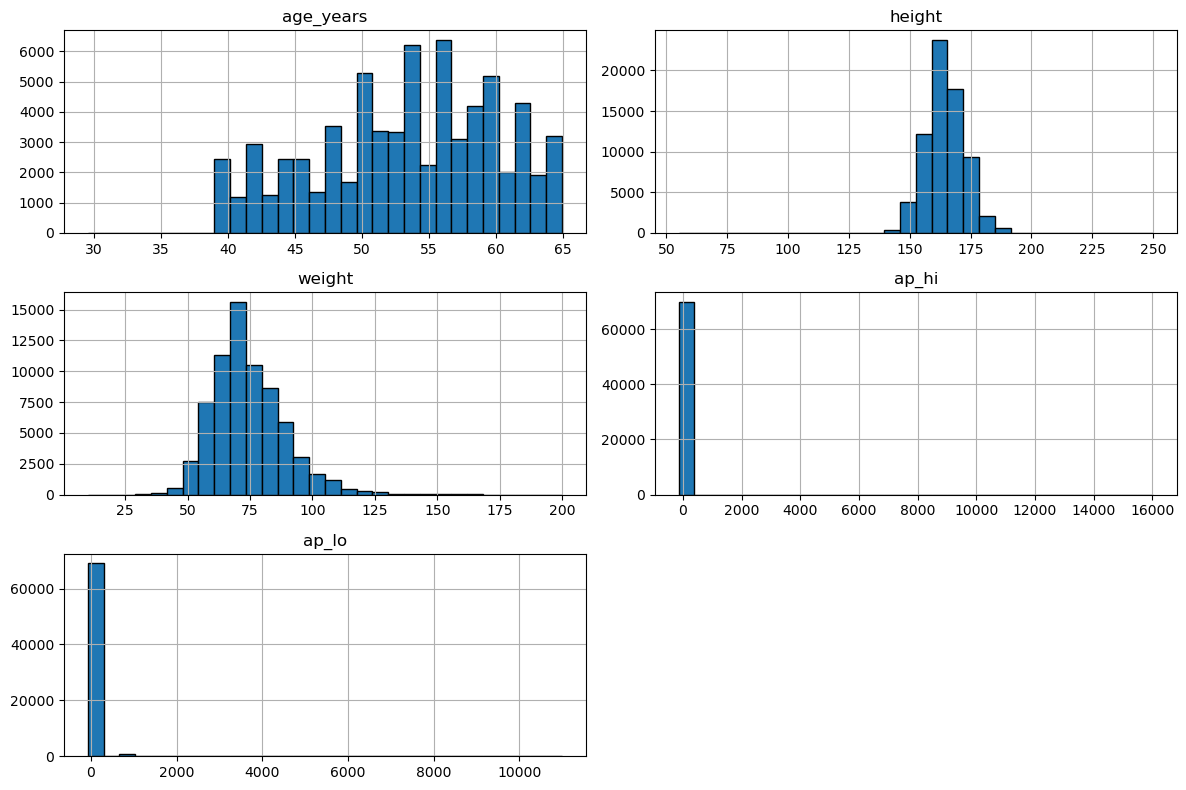

In [10]:
numerical_features = [
    "age_years", "height", "weight", "ap_hi", "ap_lo"
]

df[numerical_features].hist(
    bins=30,
    figsize=(12, 8),
    edgecolor="black"
)

plt.tight_layout()
plt.show()

Histogrami pokazuju da su godine, visina i težina približno normalno raspoređeni, sa očekivanim koncentracijama oko srednjih vrednosti populacije. Nasuprot tome, atributi **ap_hi** i **ap_lo** imaju izrazito asimetrične raspodele sa dugim desnim repovima, što ukazuje na prisustvo ekstremnih i nerealnih vrednosti.

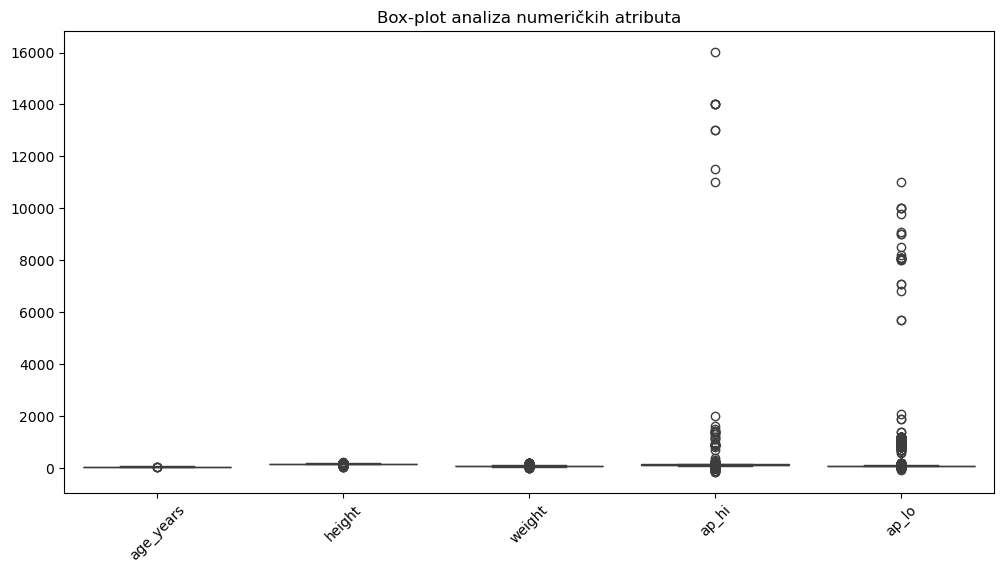

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_features])
plt.xticks(rotation=45)
plt.title("Box-plot analiza numeričkih atributa")
plt.show()

Na box-plot grafikonu uočavaju se brojni izuzeci (outlieri), naročito kod atributa **ap_hi** i **ap_lo**, što ukazuje na prisustvo ekstremnih i potencijalno nerealnih vrednosti krvnog pritiska. Za ostale numeričke atribute (godine, visina, težina) izuzeci su ređi i manje izraženi.

### Poređenje atributa u odnosu na ciljnu promenljivu

U nastavku se analizira kako se raspodele pojedinih atributa razlikuju između ispitanika sa i bez kardiovaskularne bolesti.


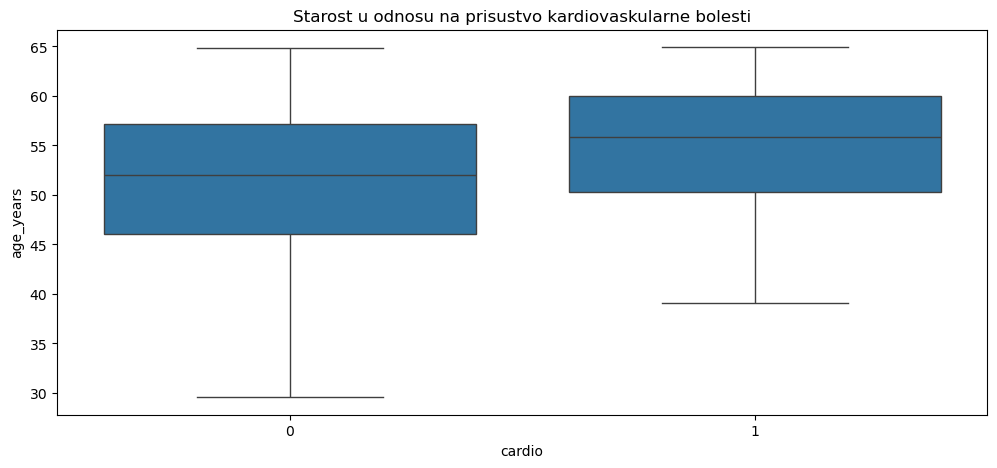

In [12]:
plt.figure(figsize=(12, 5))

sns.boxplot(x="cardio", y="age_years", data=df)
plt.title("Starost u odnosu na prisustvo kardiovaskularne bolesti")
plt.show()

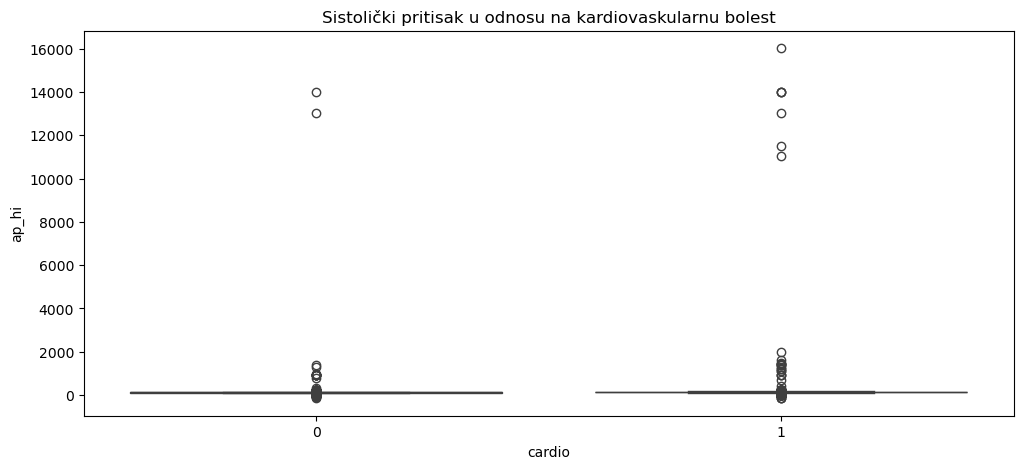

In [13]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="cardio", y="ap_hi", data=df)
plt.title("Sistolički pritisak u odnosu na kardiovaskularnu bolest")
plt.show()

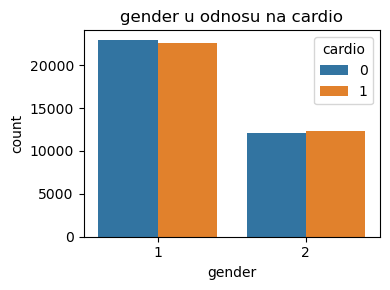

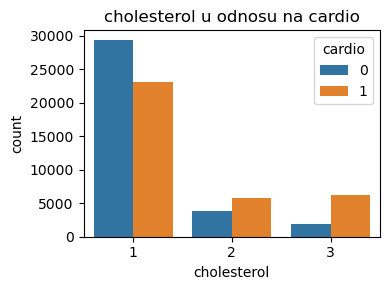

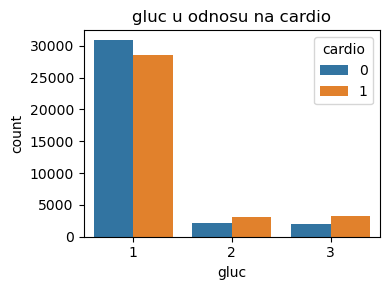

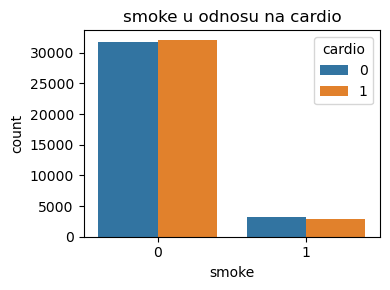

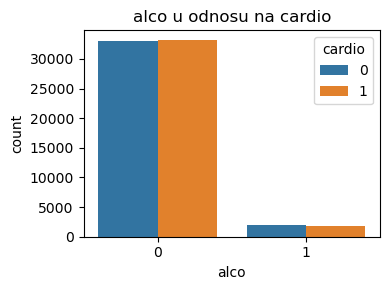

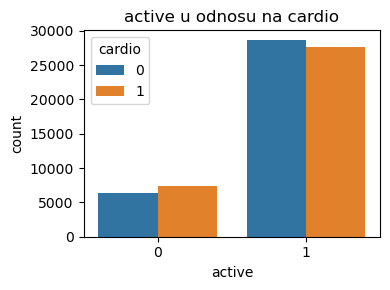

In [14]:
categorical_features = [
    "gender", "cholesterol", "gluc", "smoke", "alco", "active"
]

for col in categorical_features:
    plt.figure(figsize=(4, 3))
    sns.countplot(x=col, hue="cardio", data=df)
    plt.title(f"{col} u odnosu na cardio")
    plt.legend(title="cardio")
    plt.tight_layout()
    plt.show()

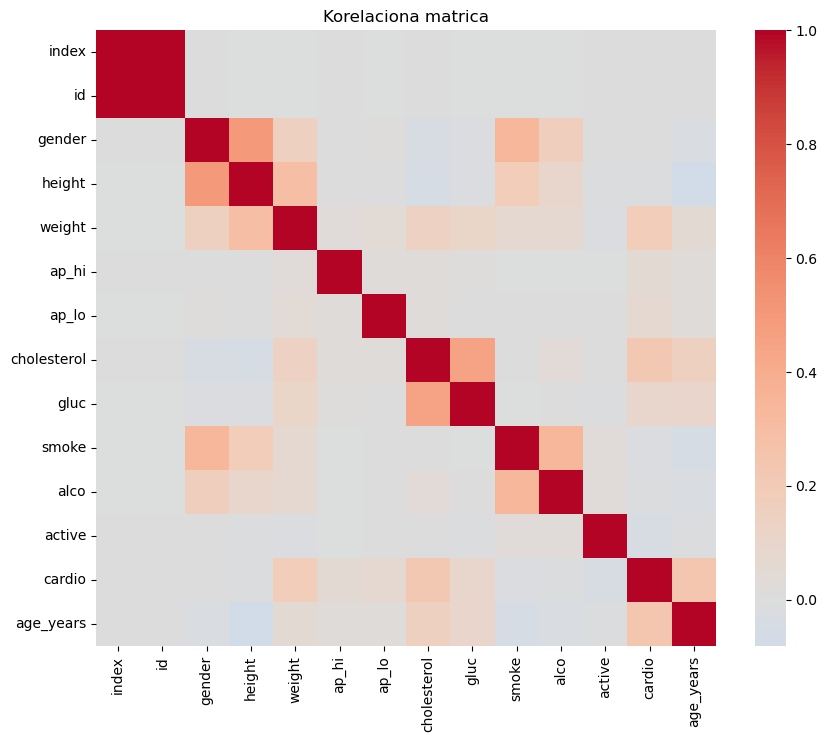

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df.corr(),
    cmap="coolwarm",
    center=0,
    annot=False
)
plt.title("Korelaciona matrica")
plt.show()

Korelaciona matrica pokazuje da ne postoji jaka linearna povezanost između većine atributa i ciljne promenljive **cardio**, što ukazuje na kompleksniju prirodu problema. 

Umerene pozitivne korelacije primećuju se između **age_years**, **ap_hi**, **ap_lo** i **cardio**, što je u skladu sa medicinskim očekivanjima. Takođe se vidi očekivana povezanost između **height** i **weight**, kao i između **cholesterol** i **gluc**, dok su ostale korelacije uglavnom slabe ili zanemarljive.

### Pravila za filtriranje krvnog pritiska

U analizi su primenjena sledeća ograničenja:
- Sistolički pritisak (`ap_hi`) mora biti u opsegu 90–250 mmHg
- Dijastolički pritisak (`ap_lo`) mora biti u opsegu 60–200 mmHg
- Sistolički pritisak mora biti veći od dijastoličkog

In [16]:
initial_shape = df.shape

df = df[
    (df["ap_hi"] >= 90) & (df["ap_hi"] <= 250) &
    (df["ap_lo"] >= 60) & (df["ap_lo"] <= 200) &
    (df["ap_hi"] > df["ap_lo"])
]

df.shape, initial_shape

((68497, 14), (70000, 14))

In [17]:
df = df[
    (df["height"] >= 120) & (df["height"] <= 220) &
    (df["weight"] >= 40) & (df["weight"] <= 200)
]

df.shape

(68399, 14)

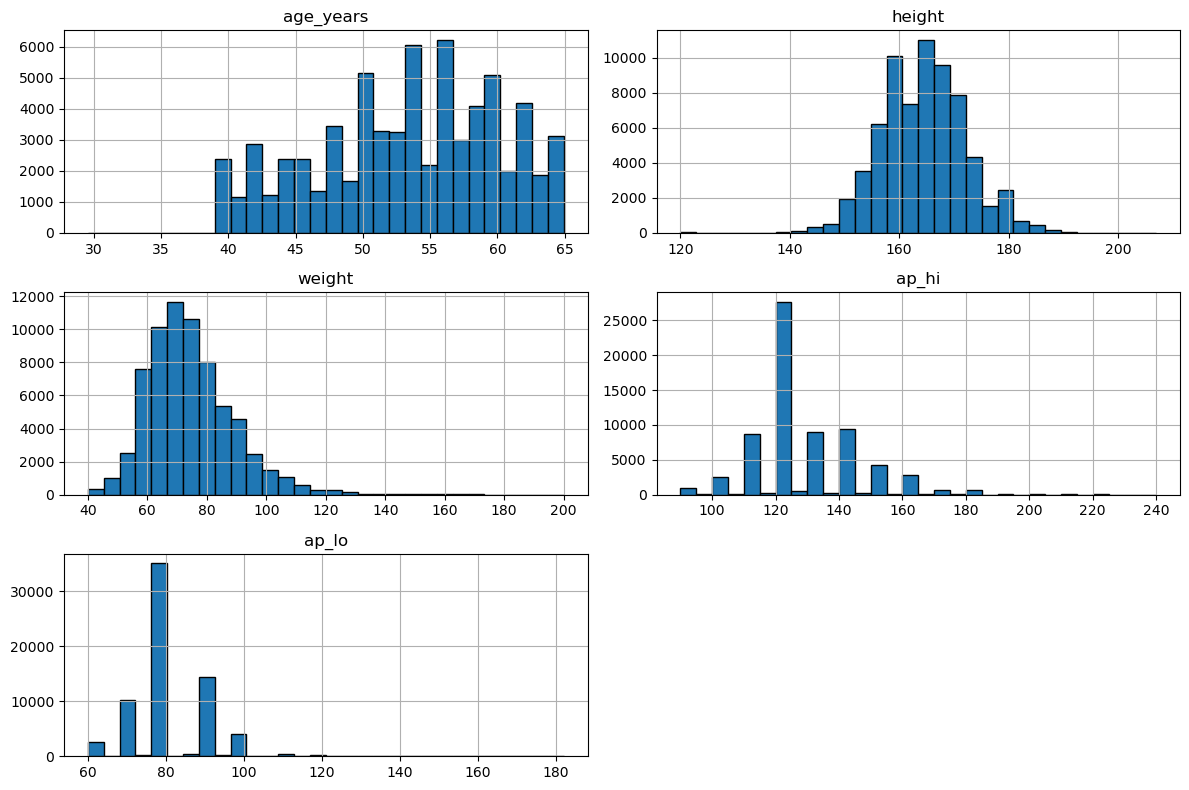

In [18]:
numerical_features = [
    "age_years", "height", "weight", "ap_hi", "ap_lo"
]

df[numerical_features].hist(
    bins=30,
    figsize=(12, 8),
    edgecolor="black"
)

plt.tight_layout()
plt.show()

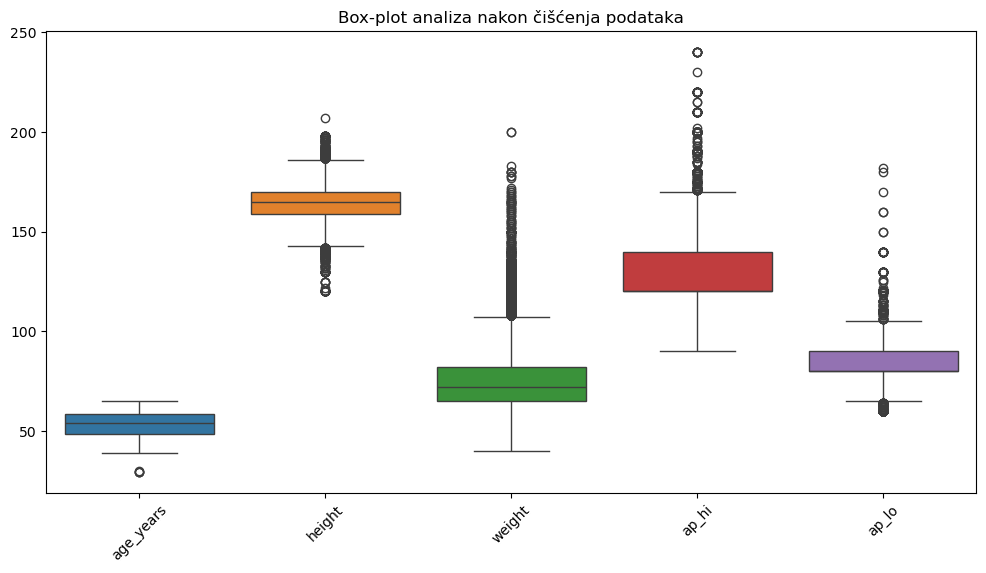

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_features])
plt.xticks(rotation=45)
plt.title("Box-plot analiza nakon čišćenja podataka")
plt.show()

In [20]:
# BMI - Body Mass Index (indeks telesne mase)

df["height_m"] = df["height"] / 100
df["BMI"] = df["weight"] / (df["height_m"] ** 2)

df[["BMI"]].describe()

,BMI
count,68399.000000
mean,27.471012
std,5.249547
min,13.520822
25%,23.875115
50%,26.346494
75%,30.119376
max,108.169847


In [21]:
# Pulsni pritisak

df["pulse_pressure"] = df["ap_hi"] - df["ap_lo"]
df["pulse_pressure"].describe()

count    68399.000000
mean        45.371526
std         11.591200
min          5.000000
25%         40.000000
50%         40.000000
75%         50.000000
max        140.000000
Name: pulse_pressure, dtype: float64

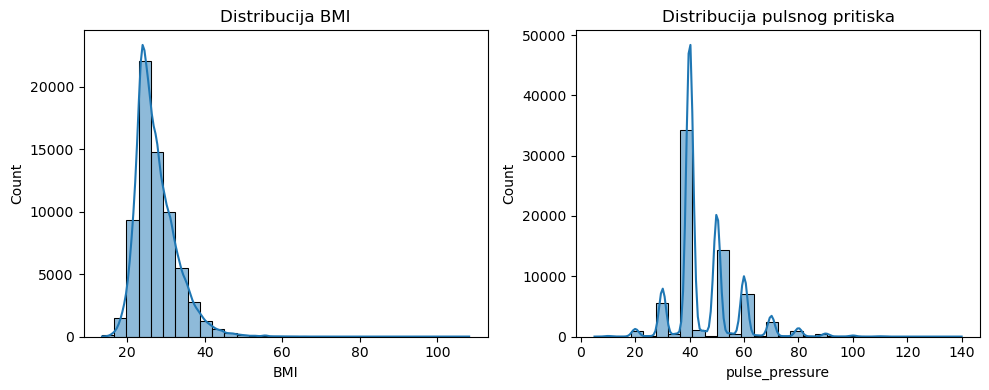

In [22]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(df["BMI"], bins=30, kde=True)
plt.title("Distribucija BMI")

plt.subplot(1, 2, 2)
sns.histplot(df["pulse_pressure"], bins=30, kde=True)
plt.title("Distribucija pulsnog pritiska")

plt.tight_layout()
plt.show()

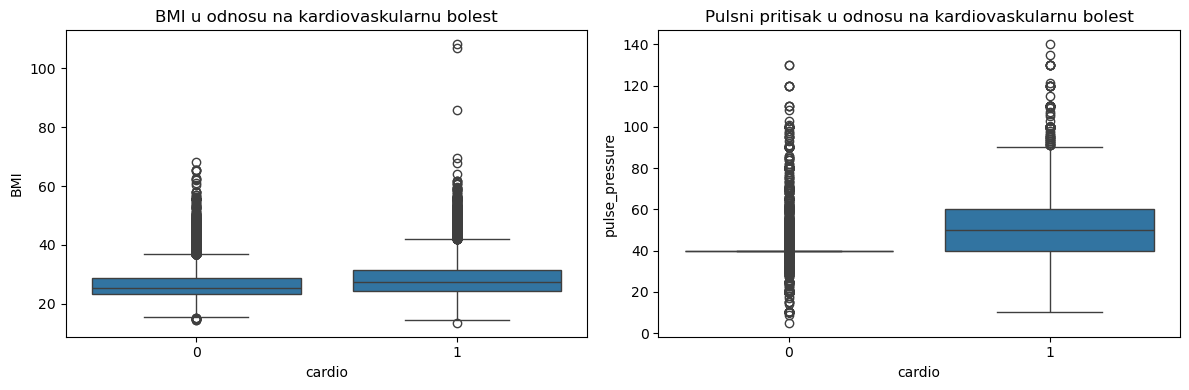

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x="cardio", y="BMI", data=df)
plt.title("BMI u odnosu na kardiovaskularnu bolest")

plt.subplot(1, 2, 2)
sns.boxplot(x="cardio", y="pulse_pressure", data=df)
plt.title("Pulsni pritisak u odnosu na kardiovaskularnu bolest")

plt.tight_layout()
plt.show()

In [24]:
initial_shape = df.shape

df = df[
    (df["BMI"] >= 15) & (df["BMI"] <= 60) &
    (df["pulse_pressure"] >= 20) & (df["pulse_pressure"] <= 100)
]

df.shape, initial_shape

((68218, 17), (68399, 17))

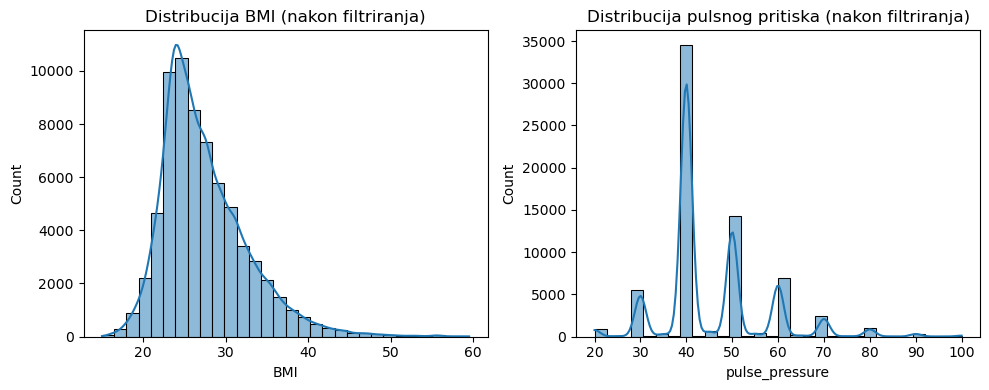

In [25]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(df["BMI"], bins=30, kde=True)
plt.title("Distribucija BMI (nakon filtriranja)")

plt.subplot(1, 2, 2)
sns.histplot(df["pulse_pressure"], bins=30, kde=True)
plt.title("Distribucija pulsnog pritiska (nakon filtriranja)")

plt.tight_layout()
plt.show()

**Ekstremne vrednosti BMI i pulsnog pritiska koje prevazilaze fiziološki realne granice uklonjene su kako bi se smanjio uticaj grešaka merenja i poboljšala stabilnost klasifikacionih modela.**

In [26]:
# Priprema podataka za modeliranje

cols_to_drop = [
    "index",
    "id",
    "height",
    "height_m",
    "weight"
]

df = df.drop(columns=cols_to_drop)

X = df.drop(columns=["cardio"])
y = df["cardio"]

X.shape, y.shape

((68218, 11), (68218,))

### Podela podataka na trening i test skup

Podaci su podeljeni u odnosu 80% / 20%, pri čemu se test skup koristi isključivo
za evaluaciju generalizacije modela.


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y # čuvamo odnos klasa u oba skupa
)

X_train.shape, X_test.shape

((54574, 11), (13644, 11))

In [28]:
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns
numerical_features

Index(['gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco',
       'active', 'age_years', 'BMI', 'pulse_pressure'],
      dtype='object')

In [29]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(
    X_train[numerical_features]
)

X_test_scaled[numerical_features] = scaler.transform(
    X_test[numerical_features]
)

In [30]:
X_train_scaled[numerical_features].describe().round(2)

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,BMI,pulse_pressure
count,54574.00,54574.00,54574.00,54574.00,54574.00,54574.00,54574.00,54574.00,54574.00,54574.00,54574.00
mean,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.73,-2.24,-2.29,-0.54,-0.40,-0.31,-0.24,-2.03,-3.51,-2.39,-2.24
25%,-0.73,-0.41,-0.15,-0.54,-0.40,-0.31,-0.24,0.49,-0.73,-0.69,-0.47
50%,-0.73,-0.41,-0.15,-0.54,-0.40,-0.31,-0.24,0.49,0.10,-0.21,-0.47
75%,1.37,0.81,0.93,-0.54,-0.40,-0.31,-0.24,0.49,0.75,0.51,0.41
max,1.37,5.68,10.59,2.41,3.09,3.21,4.21,0.49,1.72,6.17,4.82


**Zašto smo morali da uradimo skaliranje?**

Raspon originalnih atributa:

- ap_hi → ~90–250
- age_years → ~40–65
- BMI → ~15–60
- cholesterol → 1–3
- smoke → 0–1

Ako ih ostavimo takve:

- atribut sa većim numeričkim opsegom dominira učenjem
- model pogrešno smatra da je ap_hi važniji od cholesterol, samo zato što ima veće brojeve

### Baseline model – Logistička regresija

In [82]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [83]:
y_pred = log_reg.predict(X_test_scaled)

In [33]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy: 0.7268396364702433
Precision: 0.7488494411571335
Recall: 0.6744633604737231
F1 score: 0.7097125944388192


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6889
           1       0.75      0.67      0.71      6755

    accuracy                           0.73     13644
   macro avg       0.73      0.73      0.73     13644
weighted avg       0.73      0.73      0.73     13644



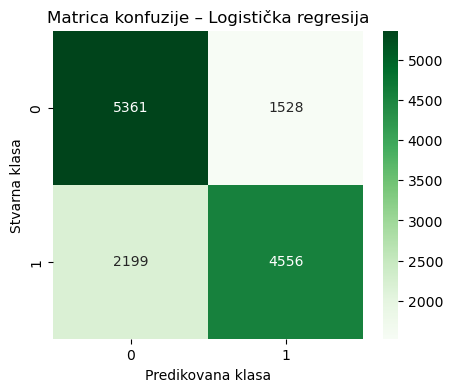

In [35]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predikovana klasa")
plt.ylabel("Stvarna klasa")
plt.title("Matrica konfuzije – Logistička regresija")
plt.show()

In [36]:
coef_df = pd.DataFrame({
    "feature": X_train_scaled.columns,
    "coefficient": log_reg.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df

,feature,coefficient
1,ap_hi,0.449474
2,ap_lo,0.380734
8,age_years,0.344737
3,cholesterol,0.339226
10,pulse_pressure,0.338124
9,BMI,0.143735
0,gender,0.020831
5,smoke,-0.041103
6,alco,-0.056612
4,gluc,-0.071227


- pozitivan koeficijent je veća verovatnoća cardio = 1
- negativan koeficijent je zaštitni efekat

### Decision Tree

In [37]:
dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42
)

dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=20, min_samples_split=50,
                       random_state=42)

In [38]:
y_pred_dt = dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 score:", f1_score(y_test, y_pred_dt))

Accuracy: 0.7332893579595426
Precision: 0.7577763070814031
Recall: 0.6780162842339008
F1 score: 0.7156809125712946


In [39]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6889
           1       0.76      0.68      0.72      6755

    accuracy                           0.73     13644
   macro avg       0.74      0.73      0.73     13644
weighted avg       0.74      0.73      0.73     13644



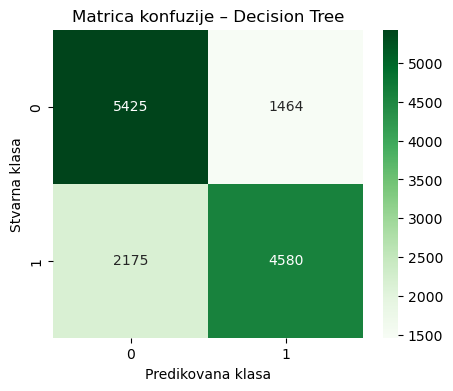

In [40]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predikovana klasa")
plt.ylabel("Stvarna klasa")
plt.title("Matrica konfuzije – Decision Tree")
plt.show()

In [41]:
feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": dt.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance

,feature,importance
1,ap_hi,0.779264
8,age_years,0.125023
3,cholesterol,0.077679
9,BMI,0.006904
4,gluc,0.006517
2,ap_lo,0.003961
5,smoke,0.000652
0,gender,0.000000
6,alco,0.000000
7,active,0.000000


**Decision Tree pokazuje blago poboljšanje performansi u odnosu na logističku regresiju**

### Random Forest

In [42]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=20, min_samples_split=50,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [43]:
y_pred_rf = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 score:", f1_score(y_test, y_pred_rf))

Accuracy: 0.7331427733802404
Precision: 0.7588098404255319
Recall: 0.6757957068837898
F1 score: 0.7149009474590869


In [44]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6889
           1       0.76      0.68      0.71      6755

    accuracy                           0.73     13644
   macro avg       0.74      0.73      0.73     13644
weighted avg       0.74      0.73      0.73     13644



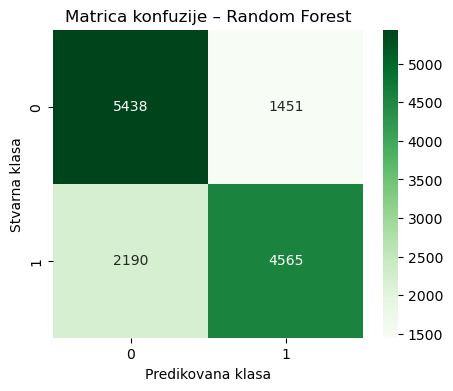

In [45]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predikovana klasa")
plt.ylabel("Stvarna klasa")
plt.title("Matrica konfuzije – Random Forest")
plt.show()

In [46]:
feature_importance_rf = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance_rf

,feature,importance
1,ap_hi,0.346235
2,ap_lo,0.208446
10,pulse_pressure,0.182254
8,age_years,0.115901
3,cholesterol,0.088348
9,BMI,0.037228
4,gluc,0.009499
7,active,0.005647
5,smoke,0.002451
0,gender,0.002343


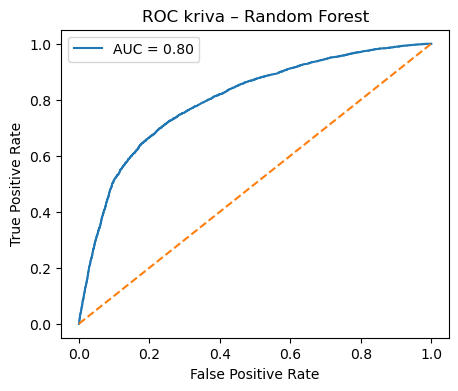

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = rf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC kriva – Random Forest")
plt.legend()
plt.show()

Za Random Forest model dobijena je AUC vrednost od 0.80, što ukazuje na
dobru separaciju između pacijenata sa i bez kardiovaskularne bolesti.
ROC kriva se značajno nalazi iznad dijagonale slučajnog klasifikatora,
što potvrđuje kvalitet modela kao finalnog rešenja.

**Iako Random Forest predstavlja snažniji model, imamo samo blagi napredak u performansama u odnosu na Decision Tree, što ukazuje da su ograničenja modela prvenstveno uslovljena kvalitetom dostupnih atributa.**

In [48]:
comparison_df = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Decision Tree",
        "Random Forest"
    ],
    "Accuracy": [
        0.7268,
        0.7333,
        0.7331
    ],
    "Precision": [
        0.7488,
        0.7578,
        0.7588
    ],
    "Recall (class 1)": [
        0.6745,
        0.6780,
        0.6758
    ],
    "F1-score": [
        0.7097,
        0.7157,
        0.7149
    ]
})

comparison_df

,Model,Accuracy,Precision,Recall (class 1),F1-score
0,Logistic Regression,0.7268,0.7488,0.6745,0.7097
1,Decision Tree,0.7333,0.7578,0.6780,0.7157
2,Random Forest,0.7331,0.7588,0.6758,0.7149


### Optimizacija hiperparametara

#### Optimizacija hiperparametara – Decision Tree

In [68]:
dt = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    "max_depth": [3, 5, 8, 12, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(
    dt, param_grid_dt,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
print(grid_dt.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [70]:
y_pred_dt_tuned = best_dt.predict(X_test)

print(classification_report(y_test, y_pred_dt_tuned))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      6889
           1       0.74      0.70      0.72      6755

    accuracy                           0.73     13644
   macro avg       0.73      0.73      0.73     13644
weighted avg       0.73      0.73      0.73     13644



#### Optimizacija hiperparametara – Random Forest

In [54]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators": [200, 300],
    "max_depth": [8, 12],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"],
    "class_weight": ["balanced"]
}

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,         
    cv=3,             
    scoring="f1",
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

best_rf = search.best_estimator_

print("Najbolji parametri:")
print(search.best_params_)

Najbolji parametri:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 12, 'class_weight': 'balanced'}


In [51]:
y_pred_rf_tuned = best_rf.predict(X_test)

print(classification_report(y_test, y_pred_rf_tuned))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6889
           1       0.75      0.69      0.72      6755

    accuracy                           0.73     13644
   macro avg       0.74      0.73      0.73     13644
weighted avg       0.74      0.73      0.73     13644



Optimizacijom hiperparametara postigli smo robusniji i bolje balansiran model, sa blagim unapređenjem performansi za klasu obolelih, uz očuvanje računske efikasnosti.

### Interpretabilnost modela – SHAP analiza

In [64]:
import shap

rf_for_shap = best_rf

if hasattr(rf_for_shap, "feature_names_in_"):
    X_test_shap = X_test[rf_for_shap.feature_names_in_].copy()
else:
    X_test_shap = X_test.copy()

print("X_test_shap shape:", X_test_shap.shape)
print("Model expects:", len(getattr(rf, "feature_names_in_", X_test_shap.columns)))

X_test_shap shape: (13644, 11)
Model expects: 11


In [65]:
explainer = shap.TreeExplainer(rf_for_shap)
shap_values = explainer.shap_values(X_test_shap)

# shap_values može biti list (po klasama) ili ndarray (zavisi od verzije)
if isinstance(shap_values, list):
    sv1 = shap_values[1]  # klasa 1 = oboleli
else:
    sv = np.array(shap_values)
    # nekad je oblik (n_samples, n_features, n_classes)
    sv1 = sv[:, :, 1] if sv.ndim == 3 else sv

# Ako postoji +1 kolona (offset), odseci je
if sv1.shape[1] == X_test_shap.shape[1] + 1:
    sv1 = sv1[:, :-1]

print("sv1 shape:", sv1.shape)
print("X_test_shap shape:", X_test_shap.shape)

sv1 shape: (13644, 11)
X_test_shap shape: (13644, 11)


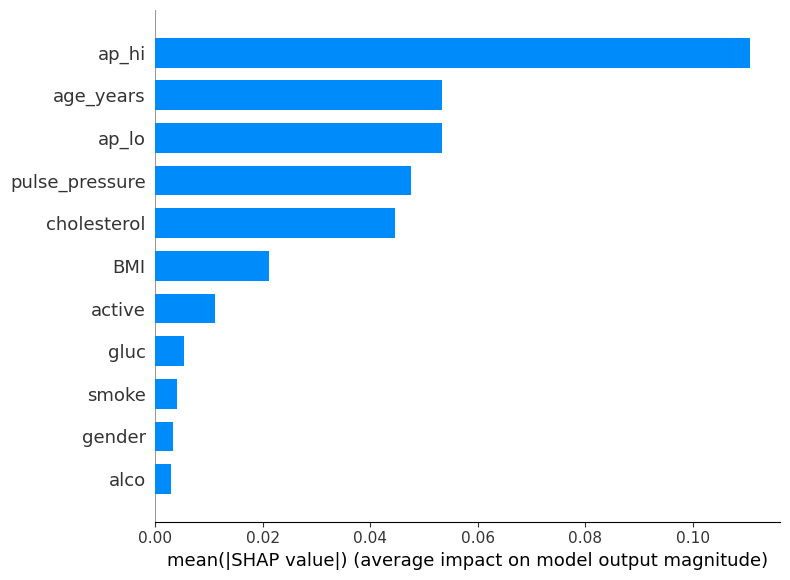

In [66]:
shap.summary_plot(
    sv1,
    X_test_shap,
    plot_type="bar"
)

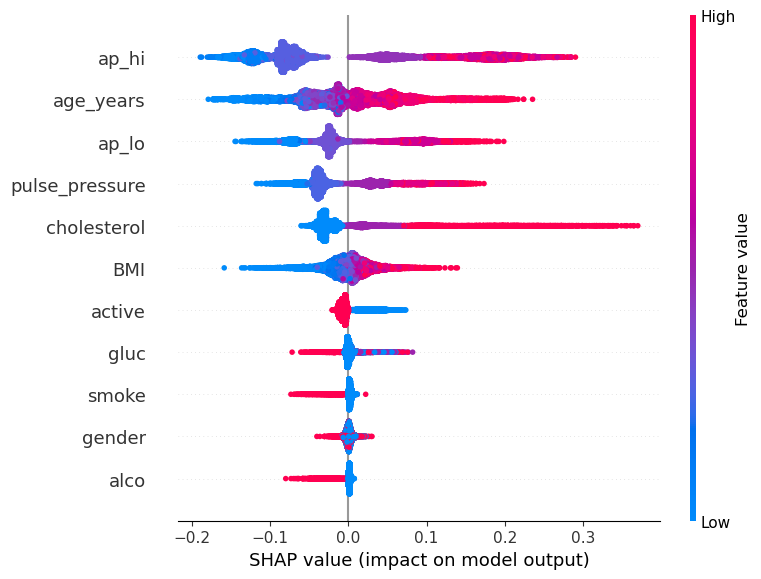

In [71]:
shap.summary_plot(
    sv1,
    X_test_shap
)

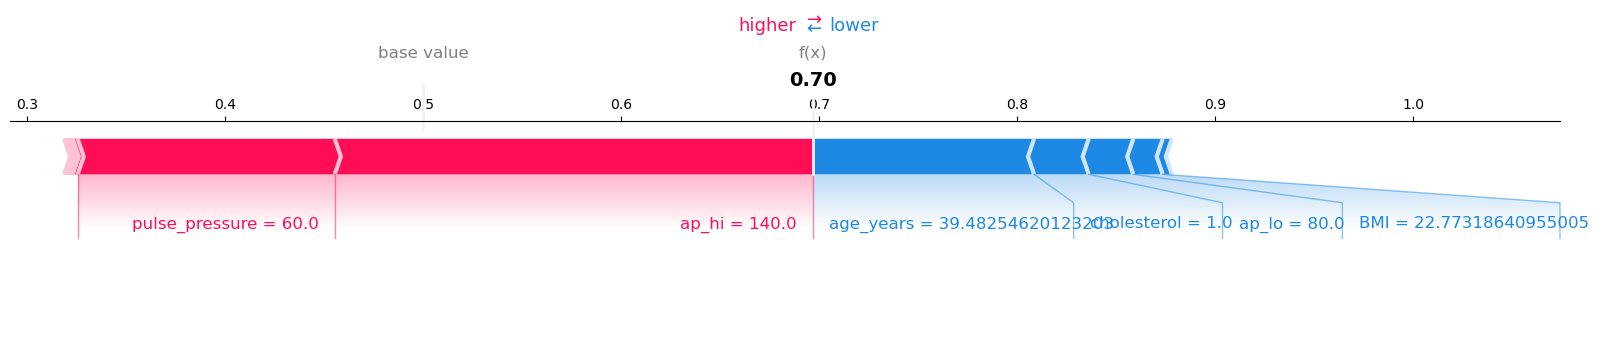

In [72]:
# lokalno objašnjenje (jedan pacijent)

i = 10  # random indeks

shap.force_plot(
    explainer.expected_value[1],
    sv1[i],
    X_test_shap.iloc[i],
    matplotlib=True
)

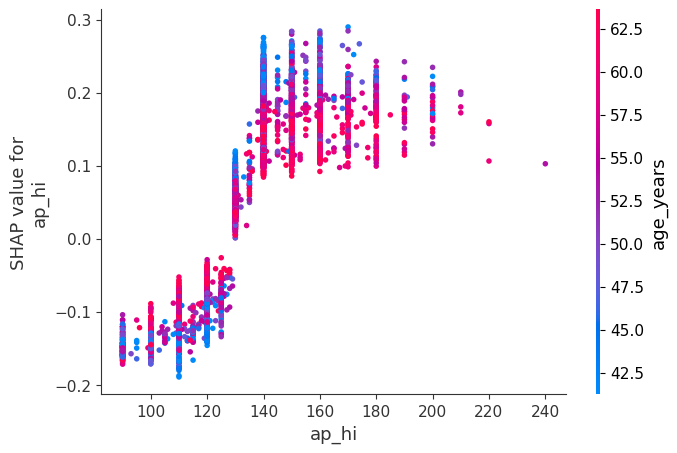

In [73]:
shap.dependence_plot(
    "ap_hi",
    sv1,
    X_test_shap
)

### LIME

In [76]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names"
)


from lime.lime_tabular import LimeTabularExplainer

rf_for_lime = best_rf 

explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=["No Cardio", "Cardio"],
    mode="classification",
    discretize_continuous=True
)

i = 10  # isti pacijent kao kod SHAP-a

exp = explainer_lime.explain_instance(
    X_test.iloc[i].values,
    rf_for_lime.predict_proba,
    num_features=8
)

exp.show_in_notebook(show_table=True)

Pored SHAP analize, korišćena je i LIME metoda za lokalnu interpretaciju pojedinačnih predikcija. LIME aproksimira ponašanje modela lokalno, pomoću jednostavnog linearnog modela u okolini posmatranog uzorka.

Rezultati dobijeni LIME metodom su konzistentni sa SHAP analizom i potvrđuju dominantan uticaj krvnog pritiska, starosti i holesterola na odluku modela.

### Redukcija dimenzionalnosti (PCA)

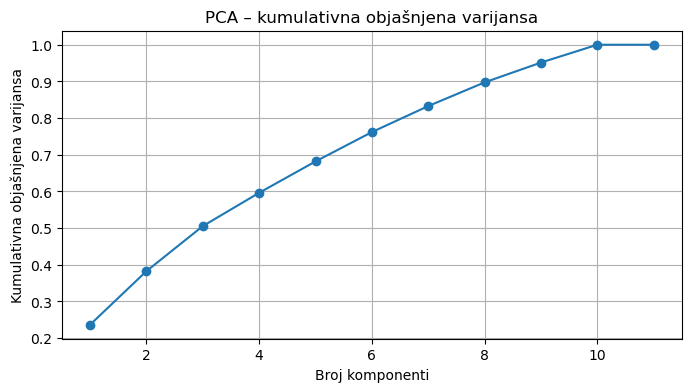

In [77]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_scaled)

explained_variance = pca.explained_variance_ratio_

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance.cumsum(),
    marker="o"
)
plt.xlabel("Broj komponenti")
plt.ylabel("Kumulativna objašnjena varijansa")
plt.title("PCA – kumulativna objašnjena varijansa")
plt.grid(True)
plt.show()

Na osnovu kumulativne objašnjene varijanse može se uočiti da:
- prvih **8 komponenti** objašnjava približno **90% ukupne varijanse**
- **9 komponenti** objašnjava približno **95% ukupne varijanse**

In [81]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Originalna dimenzija:", X_train_scaled.shape[1])
print("Nova dimenzija:", X_train_pca.shape[1])

Originalna dimenzija: 11
Nova dimenzija: 9


S obzirom na to, PCA je konfigurisana sa `n_components = 0.95`, čime je originalni prostor od **11 atributa** redukovan na **9 glavnih komponenti**.

In [80]:
log_reg_pca = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg_pca.fit(X_train_pca, y_train)
y_pred_pca = log_reg_pca.predict(X_test_pca)

print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6889
           1       0.75      0.68      0.71      6755

    accuracy                           0.73     13644
   macro avg       0.73      0.73      0.73     13644
weighted avg       0.73      0.73      0.73     13644



Nakon primene PCA, treniran je isti klasifikacioni model (Logistička regresija) nad redukovanim skupom podataka. Dobijeni rezultati pokazuju da su performanse modela (accuracy, precision, recall i F1-score) **veoma slične rezultatima bez PCA transformacije**, bez značajnog poboljšanja.

Ovo ukazuje na to da:
- originalni atributi već sadrže značajnu količinu relevantne informacije
- PCA uspešno kompresuje podatke uz minimalan gubitak informacija
- međutim, primena PCA **smanjuje interpretabilnost modela**, jer se originalni atributi zamenjuju linearnim kombinacijama (glavnim komponentama)

### Poređenje performansi modela

U tabeli ispod prikazane su performanse svih korišćenih modela na test skupu podataka. Kao glavne metrike korišćeni su **Accuracy**, **Precision**, **Recall** i **F1-score**, pri čemu je poseban akcenat stavljen na *Recall za klasu 1* (detekcija obolelih).

| Model                         | Accuracy | Precision | Recall | F1-score | Interpretabilnost |
|------------------------------|----------|-----------|--------|----------|-------------------|
| Logistička regresija         | 0.73     | 0.75      | 0.67   | 0.71     | Visoka            |
| Logistička regresija + PCA   | 0.73     | 0.75      | 0.68   | 0.71     | Niska             |
| Decision Tree                | 0.73     | 0.76      | 0.68   | 0.72     | Srednja           |
| Random Forest                | 0.73     | 0.76      | 0.68   | 0.71     | Srednja           |


Svi modeli ostvaruju vrlo slične performanse, sa accuracy vrednostima oko 73%. Decision Tree i Random Forest postižu blago bolje vrednosti **recall** i **F1-score** u odnosu na logističku regresiju, što ukazuje na njihovu sposobnost da modeluju nelinearne odnose između atributa.

Logistička regresija, iako nešto jednostavnija, pruža značajnu prednost u pogledu interpretabilnosti, što je naročito važno u domenu medicinskih aplikacija. Dodavanje PCA transformacije nije dovelo do poboljšanja performansi, ali je smanjilo interpretabilnost modela.